Epoch    0 | MAE: 15504.54 | Physics loss: 0.9934
Epoch   50 | MAE: 2404.47 | Physics loss: 0.9808
✅ Early stopping at epoch 92

📊 FINAL PINNs METRICS:
MAE  : 2379.67 MW
RMSE : 2992.97 MW
MAPE : 8.37%
R²   : 0.5816
CV   : 0.1030


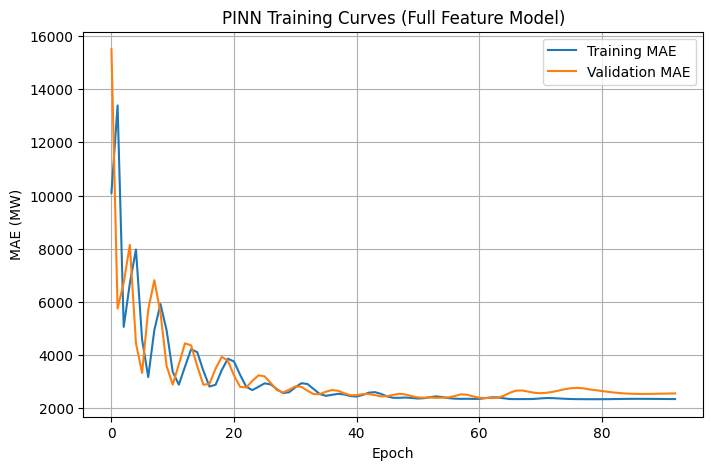

In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === STEP 1: LOAD AND PREPROCESS DATA ===
# Load datasets
weather_df = pd.read_csv('weather_features.csv')
energy_df = pd.read_csv('energy_dataset.csv')

# Align time
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True).dt.tz_localize(None)
start_time = energy_df['time'].min()
weather_df['datetime'] = pd.date_range(start=start_time, periods=len(weather_df), freq='h')
merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='datetime', how='inner')
merged_df = merged_df.drop(columns=['city_name', 'datetime', 'dt_iso'])

# Time features
merged_df['year'] = merged_df['time'].dt.year
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['month'] = merged_df['time'].dt.month
merged_df['dayofweek'] = merged_df['time'].dt.dayofweek

merged_df['sin_hour'] = np.sin(2 * np.pi * merged_df['hour'] / 24)
merged_df['cos_hour'] = np.cos(2 * np.pi * merged_df['hour'] / 24)
merged_df['sin_month'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['cos_month'] = np.cos(2 * np.pi * merged_df['month'] / 12)

# Train/Test Split
df_train = merged_df[merged_df['year'] <= 2017].copy()
df_test = merged_df[merged_df['year'] == 2018].copy()
df_train['t'] = (df_train['time'] - df_train['time'].min()).dt.total_seconds() / 3600.0
df_test['t'] = (df_test['time'] - df_train['time'].min()).dt.total_seconds() / 3600.0

# FULL feature set
features = ['t', 'sin_hour', 'cos_hour', 'sin_month', 'cos_month',
            'temp', 'generation solar', 'humidity', 'pressure', 'generation fossil gas']
target = 'total load actual'

# Drop missing and scale
df_train = df_train[features + [target]].dropna()
df_test = df_test[features + [target]].dropna()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_np = scaler_X.fit_transform(df_train[features])
y_train_np = scaler_y.fit_transform(df_train[[target]])
X_test_np = scaler_X.transform(df_test[features])
y_test_np = scaler_y.transform(df_test[[target]])

X_train = torch.tensor(X_train_np, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

# === STEP 2: DEFINE THE PINN MODEL ===
class PINNDeluxe(nn.Module):
    def __init__(self, input_dim, hidden_dim=384):
        super(PINNDeluxe, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.alpha = nn.Parameter(0.01 * torch.randn(input_dim - 1, 1))  # gentle initialization

    def forward(self, x):
        return self.net(x)

# === STEP 3: DEFINE PHYSICS LOSS ===
def physics_loss(x, y_pred, model):
    dload_dt = torch.autograd.grad(
        y_pred, x,
        grad_outputs=torch.ones_like(y_pred),
        retain_graph=True,
        create_graph=True
    )[0][:, 0:1]  # ∂Load/∂t
    rhs = x[:, 1:] @ model.alpha  # α ⋅ (all features except time)
    return nn.MSELoss()(dload_dt, rhs)

# === STEP 4: TRAINING ===
model = PINNDeluxe(input_dim=X_train.shape[1], hidden_dim=384)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

lambda_phy = 0.05    # Physics loss importance
reg_lambda = 0.0005  # Regularization
epochs = 500
patience = 30
best_mae = float('inf')
wait = 0

load_weights = y_train_np.flatten()
load_weights = (load_weights - load_weights.min()) / (load_weights.max() - load_weights.min())
load_weights = torch.tensor(1 + load_weights, dtype=torch.float32)  # weight = 1 → 2

train_maes = []
val_maes = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)

    loss_data = torch.mean(load_weights * (y_pred.squeeze() - y_train.squeeze()) ** 2)
    raw_phys_loss = physics_loss(X_train, y_pred, model)
    loss_phys = raw_phys_loss / (torch.mean(torch.abs(raw_phys_loss)) + 1e-6)
    reg_term = reg_lambda * torch.norm(model.alpha, 2)
    loss_total = loss_data + lambda_phy * loss_phys + reg_term

    loss_total.backward()
    optimizer.step()

    with torch.no_grad():
        y_val_pred = model(X_test)
        y_val_inv = scaler_y.inverse_transform(y_val_pred.detach().numpy())
        y_true_inv = scaler_y.inverse_transform(y_test_np)
        mae = mean_absolute_error(y_true_inv, y_val_inv)

        train_mae = mean_absolute_error(
            scaler_y.inverse_transform(y_train.detach().numpy()),
            scaler_y.inverse_transform(y_pred.detach().numpy())
        )

    train_maes.append(train_mae)
    val_maes.append(mae)

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:4d} | MAE: {mae:.2f} | Physics loss: {loss_phys.item():.4f}")

    if mae < best_mae:
        best_mae = mae
        torch.save(model.state_dict(), "pinn_model.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"✅ Early stopping at epoch {epoch}")
            break

    scheduler.step(mae)

# === STEP 5: EVALUATION ===
model.load_state_dict(torch.load("pinn_model.pt"))
model.eval()

with torch.no_grad():
    y_pred_scaled = model(X_test).detach().numpy()
    y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)
    y_true_inv = scaler_y.inverse_transform(y_test_np)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
r2 = r2_score(y_true_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
cv = rmse / np.mean(y_true_inv)

print("\n📊 FINAL PINNs METRICS:")
print(f"MAE  : {mae:.2f} MW")
print(f"RMSE : {rmse:.2f} MW")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")
print(f"CV   : {cv:.4f}")

# === STEP 6: PLOT TRAINING CURVES ===
plt.figure(figsize=(8,5))
plt.plot(train_maes, label="Training MAE")
plt.plot(val_maes, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (MW)")
plt.title("PINN Training Curves (Full Feature Model)")
plt.legend()
plt.grid(True)
plt.show()
